In [1]:
import pandas as pd
import numpy as np 
import re 
import networkx as nx

In [3]:
df_revs = pd.read_csv('/mnt/39b89ea8-8334-43c3-b50b-918be75d4569/Dropbox/Momolbox/code/libro/cap_controversies/ok/WikipediaBush-20230416071703.csv',sep=';')
df_revs['date'] = pd.to_datetime(df_revs['Time(calendar)'])

In [4]:
df_revs

,PageTitle,PageID,RevisionID,Time(calendar),Time(milliseconds),InteractionType,WordCount,IsAnonymous,ActiveUser,TargetAuthor,UndoTarget,RedoTarget,date
0,George W. Bush,3414021,331658893,2001-11-27T16:04:38Z,1003909929000,ADDED,435,0,Aristotle~enwiki,NaN,NaN,NaN,2001-11-27 16:04:38+00:00
1,George W. Bush,3414021,331658894,2001-11-27T16:39:21Z,1006873478000,ADDED,6,0,151.188.17.xxx,NaN,NaN,NaN,2001-11-27 16:39:21+00:00
2,George W. Bush,3414021,331658894,2001-11-27T16:39:21Z,1006873478000,DELETED,3,0,151.188.17.xxx,Aristotle~enwiki,Aristotle~enwiki,NaN,2001-11-27 16:39:21+00:00
3,George W. Bush,3414021,331658895,2001-12-08T22:34:09Z,1006875561000,DELETED,6,0,The ansible,151.188.17.xxx,151.188.17.xxx,NaN,2001-12-08 22:34:09+00:00
4,George W. Bush,3414021,331658895,2001-12-08T22:34:09Z,1006875561000,RESTORED,3,0,The ansible,Aristotle~enwiki,151.188.17.xxx,Aristotle~enwiki,2001-12-08 22:34:09+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8318,George W. Bush,3414021,8576460,2004-02-12T21:23:38Z,1076617166000,DELETED,1,0,JonathanDP81,Hephaestos,Morwen,213.200.142.253,2004-02-12 21:23:38+00:00
8319,George W. Bush,3414021,8576464,2004-02-12T21:27:31Z,1076617651000,ADDED,70,1,199.29.196.5,NaN,NaN,NaN,2004-02-12 21:27:31+00:00
8320,George W. Bush,3414021,8576464,2004-02-12T21:27:31Z,1076617651000,DELETED,8,1,199.29.196.5,64.230.111.220,64.230.111.220,NaN,2004-02-12 21:27:31+00:00
8321,George W. Bush,3414021,8576464,2004-02-12T21:27:31Z,1076617651000,DELETED,35,1,199.29.196.5,JonathanDP81,JonathanDP81,NaN,2004-02-12 21:27:31+00:00


## Metriche

In [5]:
revisions_df = df_revs.drop_duplicates('RevisionID')


In [6]:
df_revs['InteractionType'].value_counts()

DELETED     4430
RESTORED    3337
ADDED        556
Name: InteractionType, dtype: int64

<AxesSubplot:xlabel='date'>

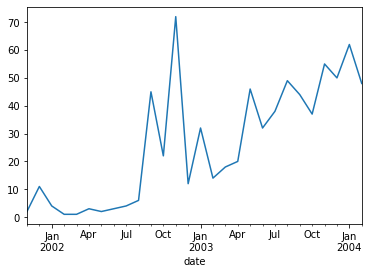

In [7]:
revisions_df.resample('M',on='date')['RevisionID'].count().plot()

<AxesSubplot:xlabel='date'>

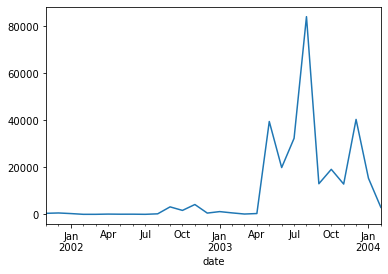

In [8]:
df_revs.resample('M',on='date')['WordCount'].sum().plot()

<AxesSubplot:ylabel='IsAnonymous'>

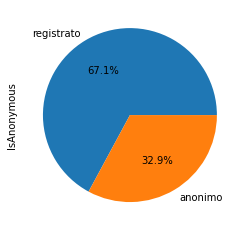

In [9]:
revisions_df['IsAnonymous'].value_counts().plot(kind='pie', autopct='%1.1f%%',labels=['registrato','anonimo'])

<AxesSubplot:>

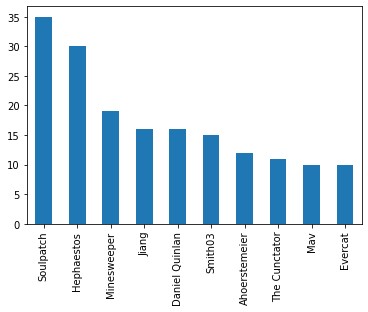

In [10]:
revisions_df_named = revisions_df[revisions_df['IsAnonymous']==0]
revisions_df_named['ActiveUser'].value_counts().head(10).plot(kind='bar')

## Network di supporto

In [11]:
restored_df = df_revs[df_revs['InteractionType']=='RESTORED']

In [12]:
positive_edges = restored_df[['ActiveUser','RedoTarget']].to_dict('records')

In [14]:
for edge in positive_edges:
    edge['Source'] = edge.pop("ActiveUser")
    edge['Target'] = edge.pop('RedoTarget')
    

In [17]:
G_supp = nx.DiGraph()

for edge in positive_edges: 
        if edge['Source'] != edge['Target']:
            if G_supp.has_edge(edge['Source'], edge['Target']):
                G_supp[edge['Source']][edge['Target']]['weight'] += 1   
            else:
                G_supp.add_edge(edge['Source'],edge['Target'],weight=1)

In [18]:
num_nodes = G_supp.number_of_nodes()
num_edges = G_supp.number_of_edges()

avg_degree = sum(dict(G_supp.degree()).values()) / float(num_nodes)
clustering = nx.average_clustering(G_supp)

assortativity = nx.degree_assortativity_coefficient(G_supp)


density = nx.density(G_supp)

In [19]:
print('n nodes: '+ str(num_nodes))
print('n edges: '+ str(num_edges))
print('clustering:' +str(clustering))
print('assortativity: '+str(assortativity))

print('density: '+str(density))

n nodes: 202
n edges: 310
clustering:0.10433762446461056
assortativity: -0.3857838516799055
density: 0.007635091867395694


In [20]:
edge_w_supp = nx.get_edge_attributes(G_supp,'weight')

In [21]:
df_support = pd.Series(edge_w_supp).reset_index()  
df_support.rename(columns= {'level_0':'Source','level_1':'Target',0:'Weight'},inplace=True)

df_support.sort_values(by='Weight',ascending = False)

,Source,Target,Weight
127,Hephaestos,Evercat,494
164,Evercat,Hephaestos,374
151,Evercat,Smith03,121
301,Camembert,Tannin,117
105,Tannin,Ahoerstemeier,116
...,...,...,...
112,DavidLevinson,Minesweeper,1
113,JohnOwens,67.119.25.241,1
114,JohnOwens,209.86.240.99,1
116,JohnOwens,Tannin,1


In [24]:
indegree_df_pos = pd.DataFrame(G_supp.in_degree(weight='weight')).rename(columns={0:'User',1:'Indegree'})

In [25]:
outdegree_df_pos = pd.DataFrame(G_supp.out_degree(weight='weight')).rename(columns={0:'User',1:'Outdegree'})

In [26]:
indegree_df_pos.sort_values(by='Indegree', ascending=False)

,User,Indegree
97,Evercat,646
55,Hephaestos,558
100,Ahoerstemeier,233
8,Tannin,209
173,Dysprosia,161
...,...,...
79,216.229.90.232,1
95,TheStick,0
188,Xiaopo,0
200,Rasmus Faber,0


In [27]:
outdegree_df_pos.sort_values(by='Outdegree', ascending=False)

,User,Outdegree
97,Evercat,644
55,Hephaestos,566
153,Morwen,295
100,Ahoerstemeier,274
8,Tannin,220
...,...,...
92,RobLa,0
34,64.26.98.90,0
94,Sannse,0
33,Dietary Fiber,0


## Network di conflitto

In [29]:
negative_edges_temp1 = restored_df[['ActiveUser','UndoTarget']].to_dict('records')

In [30]:
deleted_df = df_revs[df_revs['InteractionType']=='DELETED']

In [31]:
negative_edges_temp2 = deleted_df[['ActiveUser','UndoTarget']].to_dict('records')

In [32]:
negative_edges = negative_edges_temp1 +negative_edges_temp2
for edge in negative_edges:
    edge['Source'] = edge.pop("ActiveUser")
    edge['Target'] = edge.pop('UndoTarget')

In [33]:
G_conf = nx.DiGraph()

for edge in negative_edges:
    if edge['Source'] != edge['Target']:
    
        if G_conf.has_edge(edge['Source'], edge['Target']):
            G_conf[edge['Source']][edge['Target']]['weight'] += 1
        else:
            G_conf.add_edge(edge['Source'],edge['Target'],weight=1)
                       

In [34]:
num_nodes = G_conf.number_of_nodes()
num_edges = G_conf.number_of_edges()

avg_degree = sum(dict(G_conf.degree()).values()) / float(num_nodes)
clustering = nx.average_clustering(G_conf)

assortativity = nx.degree_assortativity_coefficient(G_conf)


density = nx.density(G_conf)

In [35]:
print('n nodes: '+ str(num_nodes))
print('n edges: '+ str(num_edges))
print('clustering:' +str(clustering))
print('assortativity: '+str(assortativity))

print('density: '+str(density))

n nodes: 364
n edges: 983
clustering:0.22704615418449708
assortativity: -0.20295606951803716
density: 0.007439530166802894


In [36]:
edge_w_conf = nx.get_edge_attributes(G_conf,'weight')

In [37]:
df_conflict = pd.Series(edge_w_conf).reset_index()  
df_conflict.rename(columns= {'level_0':'Source','level_1':'Target',0:'Weight'},inplace=True)

In [38]:
indegree_df_conf = pd.DataFrame(G_conf.in_degree(weight='weight')).rename(columns={0:'User',1:'Indegree'})
outdegree_df_conf = pd.DataFrame(G_conf.out_degree(weight='weight')).rename(columns={0:'User',1:'Outdegree'})

In [39]:
indegree_df_conf.sort_values(by='Indegree',ascending=False)

,User,Indegree
24,Hephaestos,731
29,Evercat,719
50,Henrik (old),620
65,Morwen,358
49,80.213.1.204,263
...,...,...
311,Mattworld,0
335,64.230.109.16,0
244,129.49.78.62,0
142,KamikazeArchon,0


In [41]:
outdegree_df_conf.sort_values(by='Outdegree',ascending=False)

,User,Outdegree
24,Hephaestos,719
29,Evercat,657
50,Henrik (old),619
65,Morwen,298
34,Ahoerstemeier,287
...,...,...
272,67.122.15.11,0
271,Rimez,0
270,Tedius Zanarukando,0
210,80.221.239.64,0


## Network di mutuo conflitto

In [42]:
from itertools import combinations

In [43]:
negative_edges_df = pd.DataFrame(negative_edges)

In [44]:

negative_edges_t = list(set([e['Source'] for e in negative_edges])) 

In [45]:
#traccia una connessione fra tutti gli utenti che hanno cancellato un utente 

mc_edges =[]



for e in negative_edges_t:
    filter_df = negative_edges_df[negative_edges_df['Target'] ==e]
    
    sources = filter_df['Source'].unique().tolist()
    
    mc_edges_temp = [c for c in combinations( sources,2)]
    mc_edges.extend(mc_edges_temp)
    
    
    
    
    
    


In [46]:
G_mc = nx.Graph()

for edge in mc_edges:
    G_mc.add_edge(edge[0],edge[1])

In [47]:
num_nodes = G_mc.number_of_nodes()
num_edges = G_mc.number_of_edges()

avg_degree = sum(dict(G_mc.degree()).values()) / float(num_nodes)
clustering = nx.average_clustering(G_mc)

assortativity = nx.degree_assortativity_coefficient(G_mc)


density = nx.density(G_mc)

In [48]:
print('n nodes: '+ str(num_nodes))
print('n edges: '+ str(num_edges))
print('clustering:' +str(clustering))
print('assortativity: '+str(assortativity))

print('density: '+str(density))

n nodes: 244
n edges: 3549
clustering:0.8131422179666642
assortativity: -0.08834328578202219
density: 0.11971260878364703


In [49]:
nx.write_gexf(G_mc, 'bush.gexf')

## comunita discorsive 

In [51]:
import community


partition = community.best_partition(G_mc)

df_communities = pd.DataFrame.from_dict(partition, orient='index', columns=['community'])

In [52]:
df_communities['community'].value_counts()

3    82
1    69
2    62
0    15
6    12
4     2
5     2
Name: community, dtype: int64

In [53]:
df_communities

,community
Vzbs34,3
203.59.48.208,3
205.215.134.20,1
Minesweeper,2
213.200.142.253,0
...,...
66.98.130.64,1
Flockmeal,1
Sannse,6
HarryHarry,6


In [54]:
top_3 = df_communities['community'].value_counts().head(3).index.tolist() 

In [55]:
user_dic = {}

for community in top_3:
    user_dic[community] = df_communities[df_communities['community']==community].index.tolist()

In [56]:
#estrazione testi dal dump

In [57]:
import mwxml
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [58]:
stop = stopwords.words('english')+['www','http']

In [59]:
def clean_text(text):
   
    text = re.sub(r'[^a-zA-Z]', ' ', text)
  
    text = text.lower()
   
    words = nltk.word_tokenize(text)
   
    lemmatizer = WordNetLemmatizer()
  
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop and len(word)>2]
    
    text = ' '.join(words)
    return text

In [60]:
top_3

[3, 1, 2]

In [62]:
dump = mwxml.Dump.from_file(open("/mnt/39b89ea8-8334-43c3-b50b-918be75d4569/Dropbox/Momolbox/code/libro/cap_controversies/ok/WikipediaBush-20230416071703.xml"))


texts= {}

for c in top_3: 
    texts[c] = ''




for page in dump:
    for review in page:
        for c in top_3:

            if review.user.text in user_dic[c]:
                if review.text is not None: 
                    texts[c] = texts[c] + clean_text(review.text)
                



## TF-IDF

In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [64]:
tf_idf_values={}
docs = [value for value in texts.values()]
tfIdfVectorizer=TfidfVectorizer(use_idf=True)
tfIdf = tfIdfVectorizer.fit_transform(docs)

for n,cl in enumerate(top_3):
    df_tfidf = pd.DataFrame(tfIdf[n].T.todense(), index=tfIdfVectorizer.get_feature_names_out(), columns=["TF-IDF"]).sort_values('TF-IDF', ascending=False)
    
    tf_idf_values[cl] = df_tfidf

df_tf_idf_all = pd.DataFrame() 

for cl in top_3:
    df_tf_idf_all['tfidf_'+str(cl)] = tf_idf_values[cl]['TF-IDF']

tf_idf_cols = df_tf_idf_all.columns.tolist()

for col in tf_idf_cols:
  df_tf_idf_all[re.sub('tf_idf_','',col)+'_max'] = np.where(col  == df_tf_idf_all[tf_idf_cols].idxmax(axis=1),True,False)

In [65]:
df_tf_idf_all

,tfidf_3,tfidf_1,tfidf_2,tfidf_3_max,tfidf_1_max,tfidf_2_max
bush,0.706901,0.709987,0.723240,False,False,True
state,0.232286,0.256580,0.244426,False,True,False
president,0.175103,0.173281,0.185073,False,False,True
united,0.170643,0.212317,0.206827,False,True,False
tax,0.114983,0.091759,0.039982,True,False,False
...,...,...,...,...,...,...
manned,0.000000,0.000035,0.000173,False,False,True
mandatowego,0.000000,0.000000,0.000057,False,False,True
maj,0.000000,0.000000,0.000114,False,False,True
mainly,0.000000,0.000000,0.000114,False,False,True


In [66]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [67]:
word_clouds=[]

for cl in top_3:
    
    
    filtered_df = df_tf_idf_all[df_tf_idf_all['tfidf_'+str(cl)+'_max']==True]
    wc = WordCloud(background_color="black", max_words=500, colormap='Reds')

    wc.generate_from_frequencies(filtered_df['tfidf_'+str(cl)].to_dict())
    #wc_tf_idf[str(cl)] = wc
    
    wc_dic = {'class':cl,'wc':wc}
    word_clouds.append(wc_dic)
    

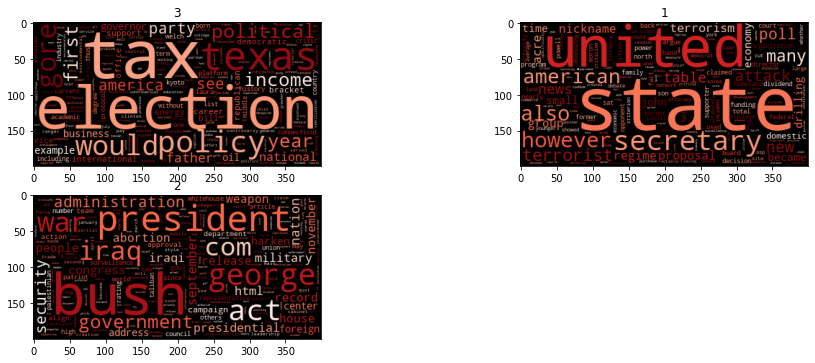

In [68]:
fig = plt.figure(figsize=(16,9))
for i in range(len(word_clouds)):
    ax = fig.add_subplot(3,2,i+1)
    ax.imshow(word_clouds[i]['wc'])
    ax.set_title(word_clouds[i]['class'])
